# **CNN**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

In [5]:
plt.rcParams['figure.figsize'] = (10,5)

In [6]:
import warnings
warnings.filterwarnings('ignore')

## **OBTENDO OS DADOS**

In [22]:
company = 'GOOG'
data = yf.download(tickers=company)
data = data.rename(columns={col: col.lower() for col in data.columns})

print(data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed
(4476, 6)


,open,high,low,close,adj close,volume
Date,,,,,,
2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897
2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276


In [13]:
df = data[:int(len(data)*.7)]
print(df.shape)

(3133, 6)


In [14]:
df_test = data[int(len(data)*.7):]
print(df_test.shape)

actual_prices = df_test['close'].values
total_dataset = pd.concat((df['close'], df_test['close']), axis=0)

(1343, 6)


## **PREPARAÇÃO DOS DADOS**

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1,1))

In [16]:
prediction_days = 80

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])

In [17]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## **CRIANDO O MODELO**

In [19]:
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=80, batch_size=80)

Epoch 1/80
39/39 [==============================] - 3s 43ms/step - loss: 0.0121
Epoch 2/80
39/39 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 3/80
39/39 [==============================] - 2s 44ms/step - loss: 8.0650e-04
Epoch 4/80
39/39 [==============================] - 2s 43ms/step - loss: 7.0961e-04
Epoch 5/80
39/39 [==============================] - 2s 44ms/step - loss: 5.8055e-04
Epoch 6/80
39/39 [==============================] - 2s 43ms/step - loss: 5.3014e-04
Epoch 7/80
39/39 [==============================] - 2s 43ms/step - loss: 4.6870e-04
Epoch 8/80
39/39 [==============================] - 2s 42ms/step - loss: 4.1677e-04
Epoch 9/80
39/39 [==============================] - 2s 43ms/step - loss: 3.9402e-04
Epoch 10/80
39/39 [==============================] - 2s 44ms/step - loss: 4.6772e-04
Epoch 11/80
39/39 [==============================] - 2s 43ms/step - loss: 3.9858e-04
Epoch 12/80
39/39 [==============================] - 2s 43ms/step - loss: 4.4101e-

In [20]:
model_inputs= total_dataset[len(total_dataset) - len(df_test) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [21]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days: x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

42/42 [==============================] - 0s 7ms/step


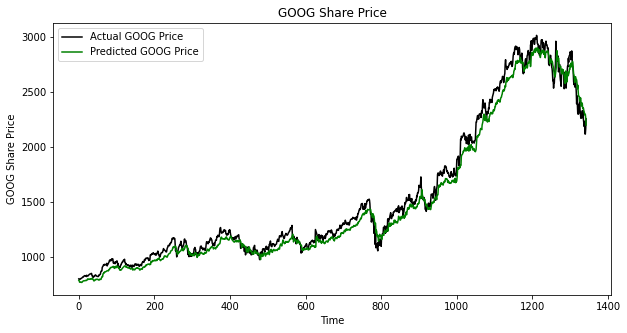

In [23]:
plt.plot(actual_prices, color='black', label= f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label= f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend([f'Actual {company} Price', f'Predicted {company} Price'])
plt.show()

In [24]:
print(mean_squared_error(actual_prices, predicted_prices))
print(r2_score(actual_prices, predicted_prices))

6208.060152540243
0.9852924919597713


In [25]:
from sklearn.dummy import DummyRegressor

dr = DummyRegressor(strategy='mean')
dr.fit(x_train, y_train)
y_pred = dr.predict(x_test)

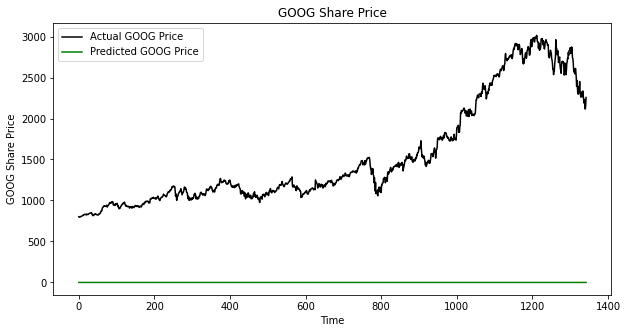

In [26]:
plt.plot(actual_prices, color='black', label= f'Actual {company} Price')
plt.plot(y_pred, color='green', label= f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend([f'Actual {company} Price', f'Predicted {company} Price'])
plt.show()

In [27]:
print(mean_squared_error(actual_prices, y_pred))
print(r2_score(actual_prices, y_pred))

2793360.9594443548
-5.617748179111624
